## Submodule-2.5 : Deep Neural Operators

## Table of Contents
#### 1. [DeepONet for Antiderivative Operators](#DeepONet-for-Antiderivative-Operators)
#### 2. [FNO for Burger's Equation](#Fourier-Neural-Operator-(FNO)-for-Burgers-Equation)

## DeepONet for Antiderivative Operators

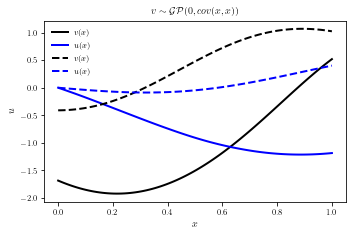

In [33]:
import tensorflow.compat as tf
import numpy as np
import scipy.io as io
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
sys.path.insert(0, 'Utilities/')
import os

from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]

d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]


####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
#gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
#ax.set_xlim([0,1.2])
#ax.set_ylim([-1.1,1.1])
#ax.axis('square')
plt.savefig("Data.png", dpi=300)




In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
np.random.seed(1234)
import sys

class DNN:
    def __init__(self):
        pass
    #initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2.0/(in_dim+out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=(in_dim, out_dim), stddev = std))
            bias = tf.Variable(tf.random.truncated_normal(shape=(1, out_dim), stddev = std))
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    def fnn_T(self, X, W, b):
        A = X #2.*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
#Load Training Data
d = np.load("antiderivative_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]


d = np.load("antiderivative_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]

#input dimension for Branch Net
u_dim = 100

#output dimension for Branch and Trunk Net
G_dim = 100

#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]

# Trunk dim
x_dim = 1

#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]

model = DNN()

def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    with tf.GradientTape() as tape:
        tape.watch([W_branch, b_branch, W_trunk, b_trunk])
        u_out_branch = model.fnn_B(v, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)       
        u_pred = tf.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
        loss = tf.reduce_mean(tf.square(u_pred - u))        
        grads = tape.gradient(loss, train_vars)
        opt.apply_gradients(zip(grads, train_vars))
        return loss, u_pred 

def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    x_test_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    v_test_tf = tf.convert_to_tensor(v, dtype=tf.float32)
    u_test_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    u_out_branch = model.fnn_B(v_test_tf, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x_test_tf, W_trunk, b_trunk)       
    u_pred = tf.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    loss = tf.reduce_mean(tf.square(u_pred - u))        
    return loss, u_pred 

    
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk =   model.hyper_initial(layers_x)

n = 0
nmax = 10000
lr = 5e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
optimizer = tf.optimizers.Adam(learning_rate=lr)
                        
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

while n <= nmax:
    x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)
    u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
    loss_train, u_train_pred = train_step(model, W_branch, b_branch, W_trunk, \
                                          b_trunk, v_train_tf, x_train_tf, u_train_tf, \
                            optimizer)
    err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                np.linalg.norm(u_train , 2, axis=1))
    
    loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_test, u_test, \
                            optimizer)
    err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
            np.linalg.norm(u_test , 2, axis=1))
    
    if n % 100 == 0:
        print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
    train_err_list.append(err_train)
    test_err_list.append(err_test)
    train_loss_list.append(loss_train)
    test_loss_list.append(loss_test)     
    n = n + 1

    


Iteration: 0 Train_loss:0.27239248156547546, Test_loss: 0.2835567593574524
Iteration: 100 Train_loss:0.02228596992790699, Test_loss: 0.01770707033574581
Iteration: 200 Train_loss:0.0026018614880740643, Test_loss: 0.0023188337218016386
Iteration: 300 Train_loss:0.0011171480873599648, Test_loss: 0.0012615369632840157
Iteration: 400 Train_loss:0.0005895702634006739, Test_loss: 0.0008697570883668959
Iteration: 500 Train_loss:0.00040012432145886123, Test_loss: 0.0006710734451189637
Iteration: 600 Train_loss:0.0002867538423743099, Test_loss: 0.0005308122490532696
Iteration: 700 Train_loss:0.0002381444937782362, Test_loss: 0.000476754765259102
Iteration: 800 Train_loss:0.0001934523315867409, Test_loss: 0.00040854644612409174
Iteration: 900 Train_loss:0.00018055243708658963, Test_loss: 0.00037427275674417615
Iteration: 1000 Train_loss:0.00015077355783432722, Test_loss: 0.00033814736525528133
Iteration: 1100 Train_loss:0.00013003061758354306, Test_loss: 0.0003008535713888705
Iteration: 1200 Tra

Iteration: 9900 Train_loss:1.216138025483815e-05, Test_loss: 4.785596684087068e-05
Iteration: 10000 Train_loss:0.0003964070638176054, Test_loss: 6.75866031087935e-05


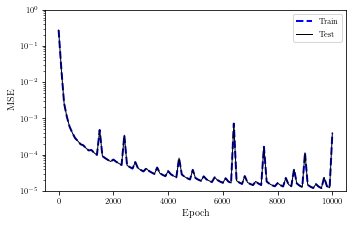

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


train_loss = np.array(train_loss_list)
test_loss =  np.array(test_loss_list)
plot_int = 100

ep = np.arange(0,nmax+1,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()




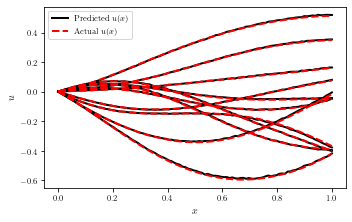

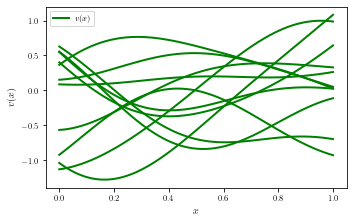

In [32]:
####
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)

## Fourier Neural Operator (FNO) for Burgers Equation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from op_utilities import *
from torch.optim import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  Fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, dtype=torch.cfloat))
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  \
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

dataloader = MatReader('burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),\
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width)
print(count_params(model))
################################################################
# Training and Prediction
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x, y 
        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x, y 

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    t2 = default_timer()
    print(f"Epoch: {ep}, Epoch TIme: {t2-t1}, Train MSE_Error: {train_mse}, Train_L2_Error :{train_l2}\
    Test L2 Error, {test_l2}")

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x, y

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

549569
0 15.446734068000296 0.05657361607183702 0.3339457216262817 0.06045839667320251
1 12.451716805000615 0.001110139383818023 0.04658006113767624 0.04165740132331848
2 12.226326422998682 0.0005919001405709423 0.03470825654268265 0.02243179500102997
3 11.489168812000571 0.0004119351410190575 0.028501902371644974 0.031155075430870056
4 10.775948636000976 0.00033760304082534274 0.029732503294944763 0.023652939200401304
5 10.844533376999607 0.0003086287170299329 0.030474056720733642 0.024312768876552582
6 12.36951098100144 0.00023943076379509876 0.024924279674887657 0.02413160800933838
7 11.942923536998933 0.0002579475615857518 0.027620342284440994 0.028488163948059083
8 12.510752312000477 0.00016503039205417736 0.021079689741134642 0.013598452359437942
9 12.611398188000749 0.00018307940219528974 0.023830914080142974 0.017519527077674867
10 12.641800423998575 0.0001726494376271148 0.02264102806150913 0.017692276537418367
11 12.511376771999494 0.00015111823646293487 0.02126334224641323 0

96 14.2510371139997 1.9679287775034026e-05 0.008145451560616494 0.007210348248481751
97 14.364761001999796 2.2066937053750734e-05 0.008727626860141753 0.0074887114763259885
98 13.810154078000778 1.764952015491872e-05 0.0076148583590984345 0.005543140843510628
99 13.667268065000826 9.631747927869582e-06 0.005297206994146109 0.004761869832873344
100 13.858728343000621 5.64081271249961e-06 0.003982056897133589 0.002641931213438511
101 13.710791482000786 4.2927952210902735e-06 0.003265339523553848 0.005490442290902137
102 14.101793099000133 6.089045189128228e-06 0.004305231098085642 0.0033915174379944802
103 13.366242557998703 4.015161936195e-06 0.002895899698138237 0.0027527760341763494
104 12.970523877000232 5.846128174198384e-06 0.003982420407235622 0.0024891886115074157
105 11.646451632001117 6.691270784813241e-06 0.004280498825013638 0.005595939382910729
106 11.66774588899898 8.056821461650544e-06 0.004962673306465149 0.0027963740006089212
107 12.406160041999101 7.175573198310304e-06 

190 13.0044563499996 2.331012026388635e-06 0.002443999854847789 0.002693435065448284
191 13.0370587540001 1.3938383190748026e-06 0.0016567083671689034 0.002638025917112827
192 13.172188485999868 1.7935553063352926e-06 0.0020823363102972507 0.0025704381987452507
193 12.960555664998537 1.868470180284021e-06 0.002304946217685938 0.0035634694993495943
194 12.833615575000294 1.8835261857930162e-06 0.0021710453256964684 0.00141661299392581
195 12.825992574998963 2.1430285369206103e-06 0.0025590237844735383 0.00265241090208292
196 11.376469505999921 1.7467068153109723e-06 0.0020234680119901897 0.0027212024107575415
197 11.532071363000796 2.2184178885709115e-06 0.002554573219269514 0.0023327207192778586
198 12.643856320999475 1.8466623765789336e-06 0.0022793517373502254 0.0015170362032949924
199 12.628874935000567 2.3043895862429054e-06 0.00237779938057065 0.003985994383692741
200 12.78820022599939 1.2123829154120358e-06 0.0015519337579607963 0.0012030553445219994
201 12.750677083999108 7.7187

283 13.02832834199944 5.360470848359e-07 0.000632635467685759 0.0008451042324304581
284 12.24753180100015 5.573957321303169e-07 0.0007239621076732874 0.0008109196089208127
285 12.882769449999614 5.89466598199806e-07 0.0008159649521112442 0.0010879063792526723
286 13.732039143000293 5.835324054004332e-07 0.0008018853375688195 0.0007989443093538285
287 13.38713948899931 5.436619515108986e-07 0.0007084536645561456 0.0008617862686514854
288 12.914369948999592 5.466258240005573e-07 0.0007161827627569438 0.0008310582768172026
289 13.116113311001754 6.058395846508801e-07 0.0007247048988938331 0.0009779816679656506
290 13.636940025000513 5.559561574841609e-07 0.0008000545371323824 0.0007965309545397758
291 13.533818737001639 5.409484882079596e-07 0.0006713351001963019 0.0007950053550302982
292 13.656648412001232 5.471102752352408e-07 0.0007179981926456094 0.0008028805628418922
293 13.27368600400041 5.581271877019844e-07 0.0007311622928828001 0.0008321503084152937
294 13.172022246999404 5.81339

376 15.13002935700024 4.513443025899733e-07 0.0005380033641122281 0.0006991225853562355
377 14.959470586998577 4.439048717586047e-07 0.0005249657719396055 0.0007174584735184908
378 14.110229742998854 4.5914446449302205e-07 0.0005356404227204621 0.0008058827184140682
379 14.020145725000475 4.708452367907512e-07 0.0005605467744171619 0.0006969361659139395
380 13.375220855999942 4.499049720507742e-07 0.0005161146172322332 0.0006963174417614937
381 13.406812610999623 4.6679074444000435e-07 0.0005292783314362168 0.0006779490550979972
382 13.756785531000787 4.606674143303735e-07 0.0005224985941313207 0.0006864469591528178
383 13.749089998000272 4.474564163103878e-07 0.0005347805600613355 0.0006837895838543772
384 13.789345080000203 4.5824227377977424e-07 0.0005148286651819944 0.0006889524031430483
385 13.77218521100076 4.508320609275529e-07 0.000515586354304105 0.0007416659686714411
386 14.264948710999306 4.649208483442635e-07 0.0005419836174696684 0.0007185353804379702
387 14.16446278700095

468 13.356857570001011 4.286956223609195e-07 0.00047119411313906314 0.0006562715349718928
469 13.438361831000293 4.2613470689900624e-07 0.00047288882406428456 0.0006576657388359308
470 13.548363661000622 4.2924969953617167e-07 0.000477093658875674 0.0006550429342314601
471 13.465148496999973 4.3003479124337216e-07 0.0004717094986699522 0.0006514510605484247
472 12.985199370999908 4.2588374153496035e-07 0.0004733933582901955 0.0006587661895900965
473 13.036863359000563 4.318949445902831e-07 0.0004718277123756707 0.0006652160361409188
474 13.58999575999951 4.27018634070464e-07 0.0004737935694865882 0.0006503326818346977
475 13.57350134599983 4.282587937964877e-07 0.0004716864237561822 0.0006555962003767491
476 13.367736881000383 4.277782782580175e-07 0.0004722681394778192 0.0006551551027223468
477 13.133684308999364 4.311137190882164e-07 0.0004772629868239164 0.0006517821038141846
478 13.62996484299947 4.2634021372833787e-07 0.00047165894554927946 0.0006556545104831458
479 13.81513570700

In [17]:
scipy.io.savemat('burger_test.mat', mdict={'pred': pred.cpu().numpy()})

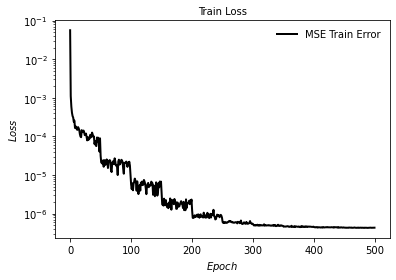

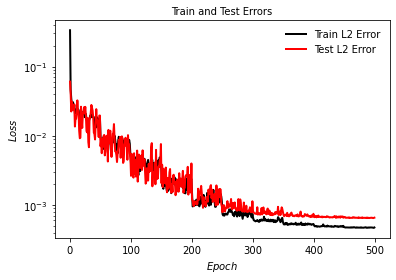

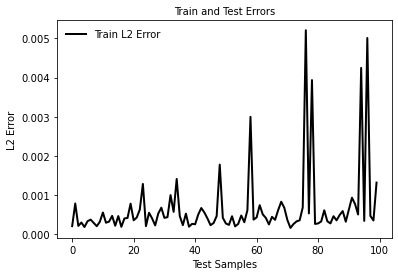

In [47]:
import matplotlib.gridspec as gridspec
ep,t, e_mse, trn_l2, tst_l2 = np.loadtxt("loss_err_fno.txt", delimiter=' ', usecols=(0, 1,2,3,4), unpack=True)
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.semilogy(ep, e_mse, '-k', lw=2.0, label="MSE Train Error")
ax.set_xlabel('$Epoch$')
ax.set_ylabel('$Loss$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Train Loss', fontsize = 10)
plt.savefig("Train_Loss.png", dpi=300)

plt.show()
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])
ax1.semilogy(ep, trn_l2, '-k', lw=2.0, label="Train L2 Error")
ax1.semilogy(ep, tst_l2, '-r', lw=2.0, label="Test L2 Error")

ax1.set_xlabel('$Epoch$')
ax1.set_ylabel('$Loss$')
ax1.legend(frameon=False, loc = 'best')
ax1.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Train_Test.png", dpi=300)

plt.show()

ba,e = np.loadtxt("eval_err.txt", delimiter=' ', usecols=(0, 1), unpack=True)
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs1[:, :])
ax2.plot(ba, e, '-k', lw=2.0, label="Train L2 Error")

ax2.set_xlabel('Test Samples')
ax2.set_ylabel("L2 Error")
ax2.legend(frameon=False, loc = 'best')
ax2.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Error.png", dpi=300)

plt.show()


L2 Error is: 0.00020575149392243475


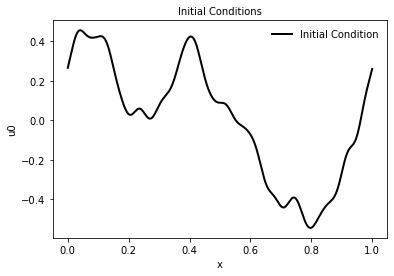

In [76]:
pred_u_plot = pred[0,:]
u_test_plot = y_test[0,:]
x_test_plot = x_test[0,:]
x_plot = np.linspace(0, 1, 1024)
err1 = np.linalg.norm(u_test_plot - pred_u_plot)
err2 = np.linalg.norm(u_test_plot)
err = err1/err2
print(f"L2 Error is: {err}")
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.plot(x_plot, pred_u_plot, '-k', lw=2.0, label="FNO Predicted")
ax.plot(x_plot, u_test_plot, '--b', lw=2.0, label="Actual Solution")
ax.set_xlabel('$x$')
ax.set_ylabel("u")
ax.legend(frameon=False, loc = 'best')
ax.set_title("Actual vs Predicetd $u$, T=1 with L2 Error = 0.0002", fontsize = 10)
plt.savefig("Solution", dpi=300)


gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[:, :])
ax1.plot(x_plot, x_test_plot, '-k', lw=2.0, label="Initial Condition")
ax1.set_xlabel('x')
ax1.set_ylabel("u0")
ax1.legend(frameon=False, loc = 'best')
ax1.set_title("Initial Conditions", fontsize = 10)
plt.savefig("Ic_test", dpi=300)
plt.show()


tensor([0.1210, 0.1235, 0.1259,  ..., 0.1138, 0.1163, 0.1188])

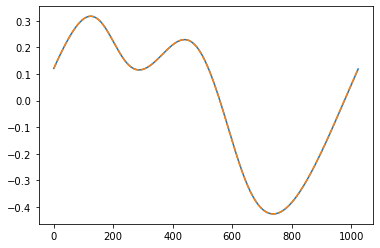

In [50]:
plt.plot(s1, "-")
plt.plot(s2,"--")